# Notebook for validating ai8x output model

In [1]:
import torch
import torchinfo
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import ai8x

import os
import json
import numpy as np
import argparse
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from pycocotools.coco import COCO

In [2]:
class MinimalSam(nn.Module):
    """
    Large size UNet model. This model also enables the use of folded data.
    """
    def __init__(
            self,
            num_classes=2,
            num_channels=3,
            dimensions=(96, 96),  # pylint: disable=unused-argument
            bias=True,
            **kwargs
    ):
        super().__init__()

        self.prep0 = ai8x.FusedConv2dBNReLU(num_channels, 64, 1, stride=1, padding=0,
                                            bias=bias, batchnorm='NoAffine', **kwargs)
        self.prep1 = ai8x.FusedConv2dBNReLU(64, 64, 1, stride=1, padding=0,
                                            bias=bias, batchnorm='NoAffine', **kwargs)
        self.prep2 = ai8x.FusedConv2dBNReLU(64, 32, 1, stride=1, padding=0,
                                            bias=bias, batchnorm='NoAffine', **kwargs)

        self.enc1 = ai8x.FusedConv2dBNReLU(32, 8, 3, stride=1, padding=1,
                                           bias=bias, batchnorm='NoAffine', **kwargs)
        self.enc2 = ai8x.FusedMaxPoolConv2dBNReLU(8, 28, 3, stride=1, padding=1,
                                                  bias=bias, batchnorm='NoAffine', **kwargs)
        self.enc3 = ai8x.FusedMaxPoolConv2dBNReLU(28, 56, 3, stride=1, padding=1,
                                                  bias=bias, batchnorm='NoAffine', **kwargs)

        self.bneck = ai8x.FusedMaxPoolConv2dBNReLU(56, 112, 3, stride=1, padding=1,
                                                   bias=bias, batchnorm='NoAffine', **kwargs)

        self.upconv3 = ai8x.ConvTranspose2d(112, 56, 3, stride=2, padding=1)
        self.dec3 = ai8x.FusedConv2dBNReLU(112, 56, 3, stride=1, padding=1,
                                           bias=bias, batchnorm='NoAffine', **kwargs)

        self.upconv2 = ai8x.ConvTranspose2d(56, 28, 3, stride=2, padding=1)
        self.dec2 = ai8x.FusedConv2dBNReLU(56, 28, 3, stride=1, padding=1,
                                           bias=bias, batchnorm='NoAffine', **kwargs)

        self.upconv1 = ai8x.ConvTranspose2d(28, 8, 3, stride=2, padding=1)
        self.dec1 = ai8x.FusedConv2dBNReLU(16, 48, 3, stride=1, padding=1,
                                           bias=bias, batchnorm='NoAffine', **kwargs)

        self.dec0 = ai8x.FusedConv2dBNReLU(48, 64, 3, stride=1, padding=1,
                                           bias=bias, batchnorm='NoAffine', **kwargs)

        self.conv_p1 = ai8x.FusedConv2dBNReLU(64, 64, 1, stride=1, padding=0,
                                              bias=bias, batchnorm='NoAffine', **kwargs)
        self.conv_p2 = ai8x.FusedConv2dBNReLU(64, 64, 1, stride=1, padding=0,
                                              bias=bias, batchnorm='NoAffine', **kwargs)
        self.conv_p3 = ai8x.FusedConv2dBN(64, 64, 1, stride=1, padding=0,
                                          bias=bias, batchnorm='NoAffine', **kwargs)

        self.conv = ai8x.FusedConv2dBN(64, num_classes, 1, stride=1, padding=0,
                                       bias=bias, batchnorm='NoAffine', **kwargs)

    def forward(self, x):  # pylint: disable=arguments-differ
        """Forward prop"""
        # Run CNN
        x = self.prep0(x)
        x = self.prep1(x)
        x = self.prep2(x)

        enc1 = self.enc1(x)                    # 8x(dim1)x(dim2)
        enc2 = self.enc2(enc1)                 # 28x(dim1/2)x(dim2/2)
        enc3 = self.enc3(enc2)                 # 56x(dim1/4)x(dim2/4)

        bottleneck = self.bneck(enc3)          # 112x(dim1/8)x(dim2/8)

        dec3 = self.upconv3(bottleneck)        # 56x(dim1/4)x(dim2/4)
        dec3 = torch.cat((dec3, enc3), dim=1)  # 112x(dim1/4)x(dim2/4)
        dec3 = self.dec3(dec3)                 # 56x(dim1/4)x(dim2/4)
        dec2 = self.upconv2(dec3)              # 28x(dim1/2)x(dim2/2)
        dec2 = torch.cat((dec2, enc2), dim=1)  # 56(dim1/2)x(dim2/2)
        dec2 = self.dec2(dec2)                 # 28x(dim1/2)x(dim2/2)
        dec1 = self.upconv1(dec2)              # 8x(dim1)x(dim2)
        dec1 = torch.cat((dec1, enc1), dim=1)  # 16x(dim1)x(dim2)
        dec1 = self.dec1(dec1)                 # 48x(dim1)x(dim2)
        dec0 = self.dec0(dec1)                 # 64x(dim1)x(dim2)

        dec0 = self.conv_p1(dec0)
        dec0 = self.conv_p2(dec0)
        dec0 = self.conv_p3(dec0)
        dec0 = self.conv(dec0)                 # num_final_channelsx(dim1)x(dim2)

        return dec0

In [3]:
###################################################################################################
#
# Dataset definition for ai8x-training
# 96x96 images cropped from COCO dataset
# Cyril Scherrer, 2025
#
###################################################################################################

"""
MinimalSam dataset
"""
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


import ai8x

import os
import json
import numpy as np
import argparse
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from pycocotools.coco import COCO


"""
Custom image dataset class
"""
class MinimalSamDataset(Dataset):
    def __init__(self, annotation_file: str, img_dir: str, img_size: int, transform=None, filtered_annotation_file=False):
        super().__init__()

        self.img_dir = img_dir
        self.img_size = img_size
        
        self.coco = COCO(annotation_file)
        self.anns = []

        self.transform = transform

        if filtered_annotation_file:
            # load from json file
            with open(filtered_annotation_file, "r") as f:
                self.filtered_anns = json.load(f)
            return
        
        # === Pre-filtering annotations without valid mask ===
        self.count_no_mask = 0 #8
        self.count_center_not_in_mask = 0 #106336
        self.count_invalid_crop = 0 #115905
        self.count_high_mask_area = 0 #175600
        
        self.filtered_anns = []
        self.anns = [ann for ann in self.coco.loadAnns(self.coco.getAnnIds()) if ann.get("iscrowd", 0) == 0]


        for ann in tqdm(self.anns):
            mask = self.coco.annToMask(ann)

            ys, xs = np.where(mask > 0)
            
            # does mask exist?
            if len(xs) == 0:
                self.count_no_mask += 1
                continue

            min_x, max_x = xs.min(), xs.max()
            min_y, max_y = ys.min(), ys.max()
            mask_center_x = (min_x + max_x) // 2
            mask_center_y = (min_y + max_y) // 2

            # is center in mask?
            if not mask[mask_center_y, mask_center_x]:
                self.count_center_not_in_mask += 1
                continue

            center_x, center_y = mask_center_x, mask_center_y
            
            # define crop box
            left = center_x - self.img_size // 2
            top  = center_y - self.img_size // 2
            right  = left + self.img_size
            bottom = top + self.img_size

            # check if crop box is valid
            if left < 0 or top < 0 or right > mask.shape[1] or bottom > mask.shape[0]:
                self.count_invalid_crop += 1
                continue

            # check if the cropped mask area occupies more than 60% of the crop area
            crop_area = self.img_size * self.img_size
            mask_area = np.sum(mask[top:bottom, left:right] > 0)
            if mask_area / crop_area > 0.6:
                self.count_high_mask_area += 1
                continue

            self.filtered_anns.append(ann)

    def __len__(self):
        return len(self.filtered_anns)
    
    def __getitem__(self, index):
        ann = self.filtered_anns[index]
        img_id = ann['image_id']
        img = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img['file_name'])

        image = Image.open(img_path).convert("RGB")
        mask = self.coco.annToMask(ann)

        cropped_image, cropped_mask = self._crop(image, mask)

        image_tensor = self.transform(cropped_image)
        mask_tensor = torch.tensor(np.array(cropped_mask), dtype=torch.long) # why unsqueeze??

        return image_tensor, mask_tensor
    
    def _crop(self, image, mask):
        ys, xs = np.where(mask > 0)
        
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        mask_center_x = (min_x + max_x) // 2
        mask_center_y = (min_y + max_y) // 2

        center_x, center_y = mask_center_x, mask_center_y

        # define crop box
        left = center_x - self.img_size // 2
        top  = center_y - self.img_size // 2
        right  = left + self.img_size
        bottom = top + self.img_size

        # could leave out resizing here 
        cropped_img = image.crop((left, top, right, bottom)).resize((self.img_size, self.img_size), Image.Resampling.LANCZOS)
        cropped_mask = Image.fromarray(mask[top:bottom, left:right]).resize((self.img_size, self.img_size), Image.Resampling.LANCZOS)

        return cropped_img, cropped_mask  #, center_x, center_y, left, top

In [4]:
def minimalsam_get_datasets(data, load_train=False, load_test=False):
   
    (data_dir, args) = data
    # data_dir = data

    transform = transforms.Compose([
        transforms.ToTensor(), # maps RGB to [0,1]
        ai8x.normalize(args=args), # maps [0,1] to [-1,1] or [-128,127]
    ])

    if load_train:
        annotation_file = os.path.join(data_dir, "annotations/instances_train2017.json")
        img_dir = os.path.join(data_dir, "train2017")
        img_size = 96
        filtered_annotation_file = os.path.join(data_dir, "annotations/filtered_anns_96x96_train2017_coco.json")
        train_dataset = MinimalSamDataset(annotation_file, img_dir, img_size, transform, filtered_annotation_file=filtered_annotation_file)

    else:
        train_dataset = None

    if load_test:
        annotation_file = os.path.join(data_dir, "annotations/instances_val2017.json")
        img_dir = os.path.join(data_dir, "val2017")
        img_size = 96
        filtered_annotation_file = os.path.join(data_dir, "annotations/filtered_anns_96x96_val2017_coco.json")
        test_dataset = MinimalSamDataset(annotation_file, img_dir, img_size, transform, filtered_annotation_file=filtered_annotation_file)

    else:
        test_dataset = None

    return train_dataset, test_dataset

In [5]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=True)
ai8x.set_device(85, True, False) # True to simulate device

Configuring device: MAX78000, simulate=True.


In [9]:
model = MinimalSam()
ai8x.fuse_bn_layers(model)

# checkpoint = torch.load("../../outputs/minimalsam_ai8x_qat_epoch7_q8.pth.tar", map_location=torch.device('cpu'))
# checkpoint = torch.load("../../outputs/1_1_2026_wd/minimalsam_ai8x_wd_epoch4.pth.tar", map_location=torch.device('cpu'))
checkpoint = torch.load("../../outputs/1_1_2026_wd/minimalsam_ai8x_wd_qat_epoch7_q8.pth.tar", map_location=torch.device('cpu'))
# checkpoint = torch.load("../../outputs/minimalsam_ai8x_epoch2_nowd.pth.tar", map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict)
model.eval()
ai8x.update_model(model)

ai8x.update_model(model)

In [7]:
_, test_dataset = minimalsam_get_datasets(("../../dataset", args), load_train=False, load_test=True)


loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.0..110.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..119.0].


preds: tensor(248., grad_fn=<SelectBackward0>)
preds: tensor(-240., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
probabilities: tensor(0., grad_fn=<SelectBackward0>)
mask: tensor(0)
preds: tensor(208., grad_fn=<SelectBackward0>)
preds: tensor(-208., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
probabilities: tensor(1.6038e-28, grad_fn=<SelectBackward0>)
mask: tensor(0)
preds: tensor(200., grad_fn=<SelectBackward0>)
preds: tensor(-200., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
probabilities: tensor(1.8049e-35, grad_fn=<SelectBackward0>)
mask: tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..107.0].


preds: tensor(248., grad_fn=<SelectBackward0>)
preds: tensor(-248., grad_fn=<SelectBackward0>)
probabilities: tensor(0., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
mask: tensor(1)
preds: tensor(232., grad_fn=<SelectBackward0>)
preds: tensor(-232., grad_fn=<SelectBackward0>)
probabilities: tensor(0., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
mask: tensor(1)
preds: tensor(264., grad_fn=<SelectBackward0>)
preds: tensor(-264., grad_fn=<SelectBackward0>)
probabilities: tensor(1.0000, grad_fn=<SelectBackward0>)
probabilities: tensor(1.1254e-07, grad_fn=<SelectBackward0>)
mask: tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..127.0].


preds: tensor(264., grad_fn=<SelectBackward0>)
preds: tensor(-264., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
probabilities: tensor(0., grad_fn=<SelectBackward0>)
mask: tensor(0)
preds: tensor(208., grad_fn=<SelectBackward0>)
preds: tensor(-208., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
probabilities: tensor(0., grad_fn=<SelectBackward0>)
mask: tensor(0)
preds: tensor(216., grad_fn=<SelectBackward0>)
preds: tensor(-216., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
probabilities: tensor(0., grad_fn=<SelectBackward0>)
mask: tensor(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..127.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128.0..127.0].


preds: tensor(184., grad_fn=<SelectBackward0>)
preds: tensor(-184., grad_fn=<SelectBackward0>)
probabilities: tensor(1., grad_fn=<SelectBackward0>)
probabilities: tensor(0., grad_fn=<SelectBackward0>)
mask: tensor(0)


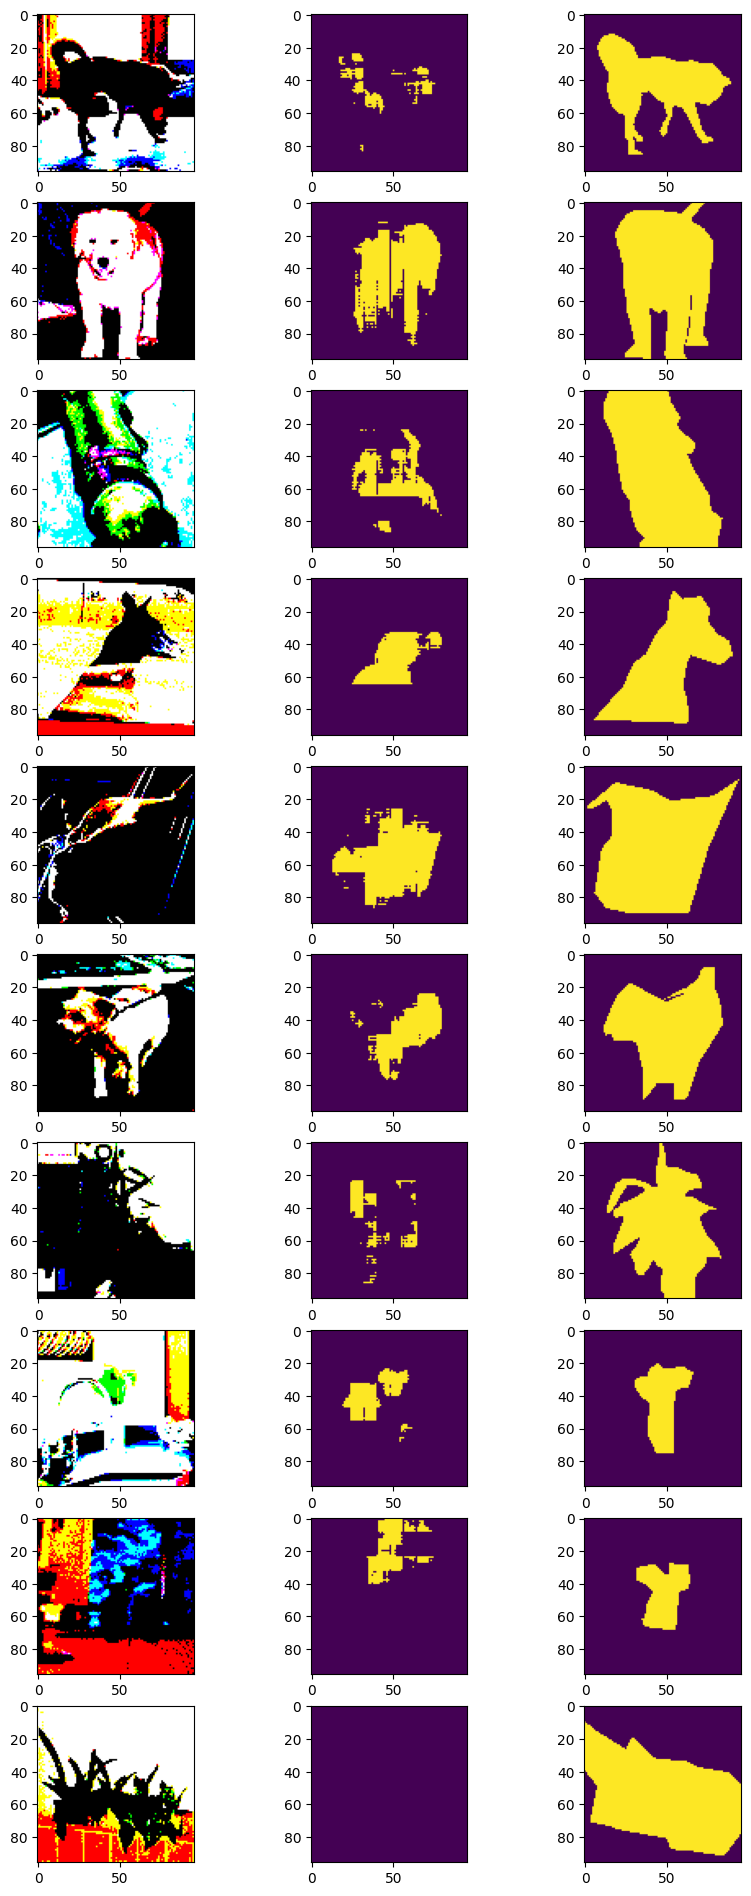

In [10]:
num_examples = 10

# create figure
fig = plt.figure(figsize=(10,24))

for i in range(0, num_examples):
    image, mask = test_dataset.__getitem__(i)

    preds = model(image.unsqueeze(0)).squeeze(0)
    # print(preds.shape)
    # print(preds[0][48][48])
    # print(preds[1][48][48])
    print("preds:", preds[0][0][0])
    print("preds:", preds[1][0][0])
    probabilities = torch.softmax(preds, dim=0)
    print("probabilities:", probabilities[0][48][48])
    print("probabilities:", probabilities[1][48][48])

    # print("probabilities.shape()", probabilities.shape)
    # print("probabilities:", probabilities)
    pred_mask = torch.argmax(probabilities, dim=0)
    print("mask:", pred_mask[48][48])
    # print("pred_mask.shape", pred_mask.shape)
    # print("pred_mask", pred_mask)
    
    plt.subplot(num_examples,3,3*i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.subplot(num_examples,3,3*i+2)
    plt.imshow(pred_mask)
    plt.subplot(num_examples,3,3*i+3)
    plt.imshow(mask)

plt.show()